<a href="https://colab.research.google.com/github/karu-rress/SDAGroupProj/blob/main/03%20-%20RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier  # Import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import shap
from sklearn.pipeline import Pipeline

In [85]:
df_origin = pd.read_csv('/content/drive/MyDrive/Android_Malware.csv', low_memory=False)

In [98]:
df = df_origin.copy()

In [99]:
# Remove leading whitespaces from column names
df.columns = df.columns.str.strip()

In [100]:
# Define the pairs of columns for differences
packet_pairs = [('Total Fwd Packets', 'Total Backward Packets'),
                ('Total Length of Fwd Packets', 'Total Length of Bwd Packets'),
                ('Fwd IAT Total', 'Bwd IAT Total'),
                ('Fwd PSH Flags', 'Bwd PSH Flags'),
                ('Fwd URG Flags', 'Bwd URG Flags'),
                ('Fwd Header Length', 'Bwd Header Length'),
                ('Fwd Packets/s', 'Bwd Packets/s'),
                ('Avg Fwd Segment Size', 'Avg Bwd Segment Size'),
                ('Fwd Avg Bytes/Bulk', 'Bwd Avg Bytes/Bulk'),
                ('Fwd Avg Packets/Bulk', 'Bwd Avg Packets/Bulk'),
                ('Fwd Avg Bulk Rate', 'Bwd Avg Bulk Rate'),
                ('Subflow Fwd Packets', 'Subflow Bwd Packets'),
                ('Subflow Fwd Bytes', 'Subflow Bwd Bytes'),
                ('Init_Win_bytes_forward', 'Init_Win_bytes_backward')]

# Convert columns to numeric before calculating differences
df = df.apply(pd.to_numeric, errors='coerce')

# Calculate differences for each pair and create separate columns
for pair in packet_pairs:
    col_name_diff = f'{pair[0]} - {pair[1]}'
    df[col_name_diff] = df[pair[0]] - df[pair[1]]

In [101]:
# List of all columns to drop
columns_to_drop = [
    'Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port',
    'Protocol', 'Timestamp', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Std',
    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Std',
    'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
    'Bwd IAT Total', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
    'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
    'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
    'Min Packet Length', 'Max Packet Length', 'Packet Length Std', 'Packet Length Variance',
    'ECE Flag Count', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
    'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
    'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
    'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min'
]
# Drop the specified columns
df = df.drop(columns=columns_to_drop, errors='ignore')

In [102]:
df['Label'] = df_origin['Label']

In [103]:
df = df.dropna()

In [104]:
def type_replace(value):
    new_value = None  # Initialize new_value
    if value == 'Android_Adware':
        new_value = 1
    elif value == 'Android_Scareware':
        new_value = 2
    elif value == 'Android_SMS_Malware':
        new_value = 3
    elif value == 'Benign':
      new_value = 4
    return new_value

df['Label'] = df['Label'].apply(type_replace)


In [105]:
features = df.drop('Label', axis=1)  # Features
target = df['Label']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)


### Lasso Regression to determine features

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Assume X_train, X_test, y_train are already defined

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Fit Lasso model
alpha = 0.9
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train, y_train)

# Ensure X_train and X_test have the same columns
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

# Get feature coefficients
coefficients = pd.Series(lasso_model.coef_, index=common_columns)


In [110]:
# Select only non-zero coefficients
non_zero_coefficients = coefficients[coefficients != 0]

# Extract features based on non-zero coefficients
selected_features = non_zero_coefficients.index

# Use selected features for training and testing sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train RandomForest model using the selected features
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_selected, y_train)

# Evaluate the model
accuracy = random_forest_model.score(X_test_selected, y_test)
print(f"RandomForest Model Accuracy: {accuracy}")

RandomForest Model Accuracy: 0.504223514458929


In [111]:
selected_features

Index(['Flow Duration', 'Bwd Packet Length Mean', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Fwd IAT Mean', 'Bwd IAT Mean',
       'Packet Length Mean', 'min_seg_size_forward', 'Active Mean',
       'Idle Mean',
       'Total Length of Fwd Packets - Total Length of Bwd Packets',
       'Fwd IAT Total - Bwd IAT Total',
       'Fwd Header Length - Bwd Header Length',
       'Fwd Packets/s - Bwd Packets/s',
       'Init_Win_bytes_forward - Init_Win_bytes_backward'],
      dtype='object')

## Random Forest (Grid Search Worked!!)

The model may have only been dumbed down to only predict adware and scareware?
Balancing techniques havent worked thus far with these features.

In [ ]:
features = df[['Packet Length Mean', 'Bwd Packet Length Mean', 'Init_Win_bytes_forward - Init_Win_bytes_backward', 'Fwd Packets/s - Bwd Packets/s',
               'Flow Packets/s', 'Total Length of Fwd Packets - Total Length of Bwd Packets', 'Active Mean',
               'Flow Bytes/s', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Flow IAT Mean', 'Flow Duration', 'min_seg_size_forward',
               'Idle Mean', 'Fwd IAT Total - Bwd IAT Total', 'Fwd Header Length - Bwd Header Length']]
target = df['Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)

best_forest = grid_search.best_estimator_


In [ ]:
# Print the results
print("Grid Search Results:")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-validated Accuracy: {grid_search.best_score_:.4f}")

# Print the performance of the best model on the test set
test_accuracy = grid_search.score(X_test_selected, y_test)
print(f"Test Set Accuracy with Best Model: {test_accuracy:.4f}")

Grid Search Results:
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Cross-validated Accuracy: 0.5131
Test Set Accuracy with Best Model: 0.5192


In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0)
forest.fit(X_train, y_train)

print("Training set accuracy: {:.3f}".format(forest.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(forest.score(X_test, y_test)))

Training set accuracy: 0.865
Test set accuracy: 0.772


In [ ]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred_forest = forest.predict(X_test)

print(classification_report(y_test, y_pred_forest))

                   precision    recall  f1-score   support

   Android_Adware       0.78      0.95      0.86     36859
Android_Scareware       0.66      0.25      0.36     12923

         accuracy                           0.77     49782
        macro avg       0.72      0.60      0.61     49782
     weighted avg       0.75      0.77      0.73     49782



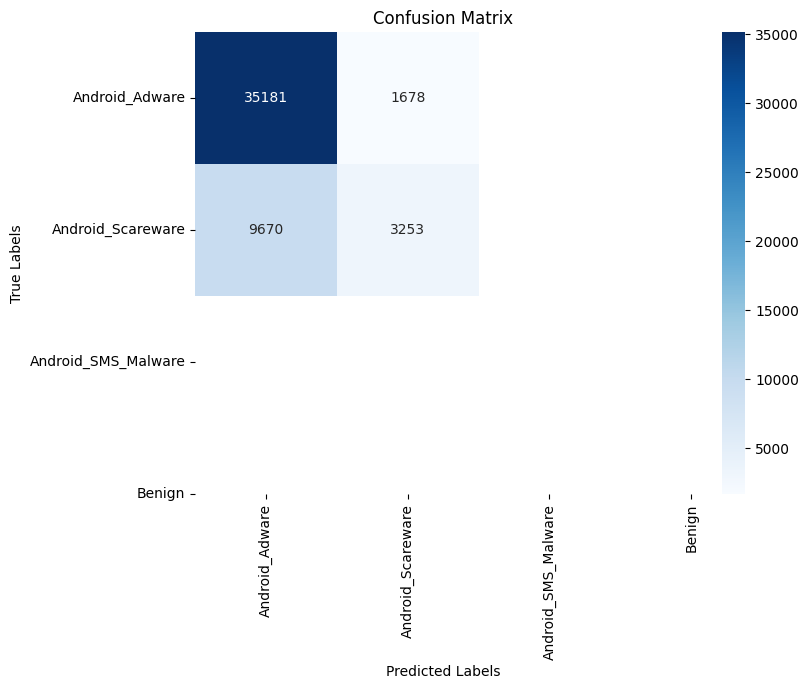

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming forest is your RandomForestClassifier
y_pred = forest.predict(X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Android_Adware', 'Android_Scareware', 'Android_SMS_Malware', 'Benign'], yticklabels=['Android_Adware', 'Android_Scareware', 'Android_SMS_Malware', 'Benign'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Solve data imbalance (No luck so far)
Trying with clean dataset

In [ ]:
df_clean = pd.read_csv('/content/drive/MyDrive/Android_Malware_clean.csv', low_memory=False)

In [ ]:
df = df_clean.copy()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Assume X_train, X_test, y_train are already defined

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Fit Lasso model
alpha = 0.9
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train, y_train)

# Ensure X_train and X_test have the same columns
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

# Get feature coefficients
coefficients = pd.Series(lasso_model.coef_, index=common_columns)

# Display only coefficients with values greater than 0
positive_coefficients = coefficients[coefficients > 0]
print("Positive Feature Coefficients:")
print(positive_coefficients)

Positive Feature Coefficients:
Flow Duration                  2.919065e-09
Total Length of Fwd Packets    1.977520e-08
Bwd Packet Length Max          3.128797e-05
Flow IAT Std                   1.931838e-08
Flow IAT Min                   1.723249e-08
Fwd IAT Std                    7.071373e-10
Fwd IAT Max                    1.576225e-09
Bwd IAT Max                    6.163550e-09
Bwd IAT Min                    4.249310e-09
Bwd Header Length              1.418344e-11
Fwd Packets/s                  2.202660e-08
Bwd Packets/s                  1.709168e-06
Max Packet Length              3.678600e-05
Packet Length Variance         2.950738e-07
Subflow Fwd Bytes              1.425019e-07
Init_Win_bytes_backward        2.617738e-07
Active Std                     5.714792e-08
Active Min                     2.304698e-08
Idle Mean                      1.114802e-09
Idle Std                       6.830086e-09
Idle Min                       3.697350e-09
dtype: float64


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.138e+05, tolerance: 2.299e+01


In [ ]:
# Select only non-zero coefficients
non_zero_coefficients = coefficients[coefficients != 0]

# Extract features based on non-zero coefficients
selected_features = non_zero_coefficients.index

# Use selected features for training and testing sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train RandomForest model using the selected features
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_selected, y_train)

# Evaluate the model
accuracy = random_forest_model.score(X_test_selected, y_test)
print(f"RandomForest Model Accuracy: {accuracy}")

selected_features

RandomForest Model Accuracy: 0.5145264152428942


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming 'df' is your DataFrame containing the features and target variable

# Select features and target variable
features = df[(['Flow Duration', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Min',
       'Bwd Packet Length Max', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Max Packet Length',
       'Packet Length Variance', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'])]
target = df['Label']

# Reduce the dataset size to, for example, 10%
small_features, _, small_target, _ = train_test_split(features, target, test_size=0.9, random_state=0)

# Split the reduced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(small_features, small_target, test_size=0.2, random_state=0)

# Initialize RandomForestClassifier with your chosen hyperparameters
forest = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, class_weight='balanced', random_state=0)

# Fit the model on the training data
forest.fit(X_train, y_train)

# Make predictions on the test set
predictions = forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Test set accuracy: {:.3f}".format(accuracy))


Test set accuracy: 0.441


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)

best_forest = grid_search.best_estimator_

# Print the results
print("Grid Search Results:")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-validated Accuracy: {grid_search.best_score_:.4f}")

# Print the performance of the best model on the test set
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Set Accuracy with Best Model: {test_accuracy:.4f}")

Grid Search Results:
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-validated Accuracy: 0.7540
Test Set Accuracy with Best Model: 0.4229


In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0)
forest.fit(X_train, y_train)

print("Training set accuracy: {:.3f}".format(forest.score(X_resampled, y_resampled)))
print("Test set accuracy: {:.3f}".format(forest.score(X_test, y_test)))

Training set accuracy: 0.811
Test set accuracy: 0.451


In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, class_weight='balanced', random_state=0)
forest.fit(X_train, y_train)

print("Training set accuracy: {:.3f}".format(forest.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(forest.score(X_test, y_test)))

Training set accuracy: 0.950
Test set accuracy: 0.441
